# The $k$-nearest neighbors (KNN, $k$-NN) algorithm

Authors:

Joseph Salmon, Alexandre Gramfort, Claire Vernade, Mathurin Massias

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import stats
from functools import partial
from sklearn import neighbors
from sklearn import datasets
from sklearn import metrics
from sklearn.utils.extmath import weighted_mode
from sklearn.base import BaseEstimator, ClassifierMixin

from tp_knn_source import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
                           rand_checkers, rand_clown, plot_2d, ErrorCurve,
                           frontiere_new, LOOCurve)

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
_ = sns.axes_style()

## Artificial Data Generation
### Question 1

In [2]:
np.random.seed(42)

n = 100
mu = [1, 1]
sigmas = [1, 1]
rand_gauss(n, mu, sigmas)

n1 = 20
n2 = 20
mu1 = [1, 1]
mu2 = [-1, -1]
sigmas1 = [1, 1]
sigmas2 = [1, 1]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

n1 = 50
n2 = 50
n3 = 50
mu1 = [1, 1]
mu2 = [-1, -1]
mu3 = [1, -1]
sigmas1 = [1, 1]
sigmas2 = [1, 1]
sigmas3 = [1, 1]
X2, y2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigmas1, sigmas2, sigmas3)

n1 = 50
n2 = 50
sigma1 = 1
sigma2 = 4
X3, y3 = rand_clown(n1, n2, sigma1, sigma2)

n1 = 150
n2 = 150
sigma = 0.1
X4, y4 = rand_checkers(n1, n2, sigma)

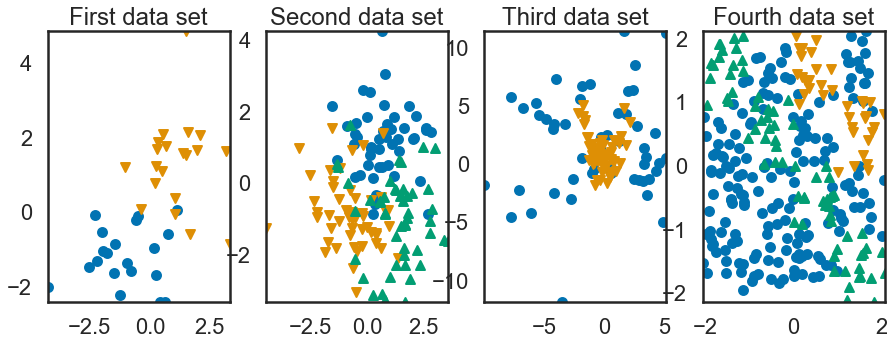

In [3]:
############################################################################
#     Displaying labeled data
############################################################################

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))

plt.subplot(141)
plt.title('First data set')
plot_2d(X1, y1)

plt.subplot(142)
plt.title('Second data set')
plot_2d(X2, y2)

plt.subplot(143)
plt.title('Third data set')
plot_2d(X3, y3)

plt.subplot(144)
plt.title('Fourth data set')
plot_2d(X4, y4)

* For the first two functions below, the dimension of the yielded points is given by the size of the input parameters mu and sigmas.


* $\textbf{rand_bi_gauss}$ returns (n1+n2) shuffled sample points from two different Gaussian distributions with the given parameters as mean and variance. For example, when len(mu) = 2: n1 points follow the same distribution as $(X_1,Y_1)$ with $X_1\sim\mathcal{N(mu1[0],sigmas1[0])}$ and $Y_1\sim\mathcal{N(mu1[1],sigmas1[1])}$, these points are labeled '1'. The other n2 points follow the same distribution as $(X_2,Y_2)$ with $X_2\sim\mathcal{N(mu2[0],sigmas2[0])}$ and $Y_2\sim\mathcal{N(mu2[1],sigmas2[1])}$, these points are labled '-1'.


* $\textbf{rand_tri_gauss}$ returns (n1+n2+n3) shuffled sample points from three different Gaussian distributions with the given parameters as mean and variance. For example, when len(mu) = 2: n1 points follow the same distribution as $(X_1,Y_1)$ with $X_1\sim\mathcal{N(mu1[0],sigmas1[0])}$ and $Y_1\sim\mathcal{N(mu1[1],sigmas1[1])}$, these points are labeled '1'. n2 points follow the same distribution as $(X_2,Y_2)$ with $X_2\sim\mathcal{N(mu2[0],sigmas2[0])}$ and $Y_2\sim\mathcal{N(mu2[1],sigmas2[1])}$, these points are labeled '2'. The other n3 points follow the same distribution as $(X_3,Y_3)$ with $X_3\sim\mathcal{N(mu3[0],sigmas3[0])}$ and $Y_3\sim\mathcal{N(mu3[1],sigmas3[1])}$, these points are labeled '3'.


* $\textbf{rand_clown}$ returns (n1+n2) shuffled sample points from two different distributions. The first one (quadratic) yields the clown's smile and the second one (gaussian) yields his face. We can see it when n1 and n2 are large enough.


* $\textbf{rand_checkers}$ returns (n1+n2) shuffled sample points that form a chess board in the upper right corner of the plane, using a combination of uniform and gaussian distributions. We can see it when n1 and n2 are large enough.


* The last column gives the labels. Each coordinate of the column corresponds to the label of the point having the same index.

## Intuitive Approach
### Question 2 : Adaptation of KNN to Regression

In [4]:
# Adaptating the k-nn algorithm to regression
def knn_regression(n_neighbors, new_point, X_train, Y_train):
    distances = []
    for i in range(X_train.shape[0]):
        distances.append(np.linalg.norm(new_point - X_train[i]))
    indexes = np.argsort(distances)
    neighbors = indexes[:n_neighbors]
    Y_neighbors = Y_train[neighbors]
    # Taking the average target value in the neighborhood instead of the predominant class
    y_pred = np.mean(Y_neighbors)
    return y_pred # Returning the predicted value for the new_point

## The $k$-NN Algorithm / Formal Approach
### Question 3 : KNN Classifier from Scratch

In [5]:
# Writing our own implementation

class KNNClassifier(BaseEstimator, ClassifierMixin):
    """ Home made KNN Classifier class"""
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        
        # Computing all pairwise distances between X and self.X_
        distances = metrics.pairwise.pairwise_distances(X, self.X_)

        # Getting sorted indices
        indexes = np.argsort(distances, axis=1)

        # Getting indices of neighbors
        neighbors = indexes[:, :self.n_neighbors]
      
        # Getting labels of neighbors
        Y_neighbors = self.y_[neighbors]

        # Finding the predicted labels y for each entry in X
        y_pred = stats.mode(Y_neighbors, axis=1)[0]

        return y_pred.astype(int)

# Comparing our implementation with scikit-learn

n_neighbors = 1

def compare(i, X, y):
    X_train = X[::2]
    Y_train = y[::2]
    X_test = X[1::2]
    Y_test = y[1::2]

    # Our classifier
    knn = KNNClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)

    # Scikit-learn
    sknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    sknn.fit(X_train, Y_train)
    Y_pred_skl = sknn.predict(X_test)

    # Checking that all labels match
    if np.all(list(Y_pred_skl) == list(Y_pred)):
        print(f'All the labels match for dataset {i}.')
    else:
        print(f"Labels don't match for dataset {i}.")
        
# Comparing for dataset 1
compare(1, X1, y1)

# Comparing for dataset 2
compare(2, X2, y2)

# Comparing for dataset 3
compare(3, X3, y3)
        
# Comparing for dataset 4
compare(4, X4, y4)

All the labels match for dataset 1.
All the labels match for dataset 2.
All the labels match for dataset 3.
All the labels match for dataset 4.


It seems like our predictions correspond to the ones yielded by scikit-learn's classifier. It means that our implementation is correct.

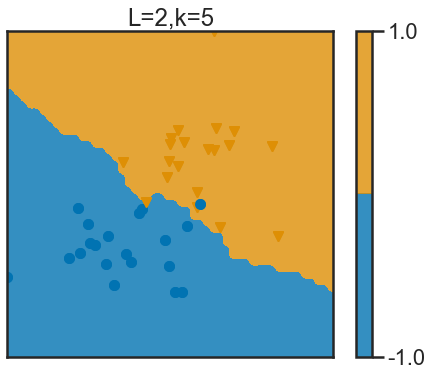

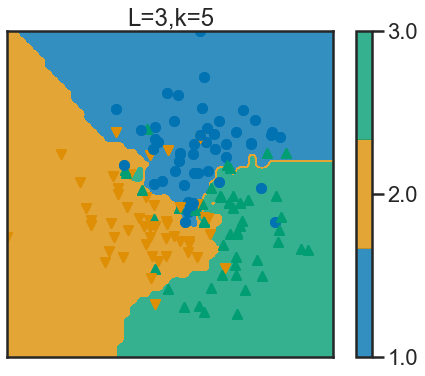

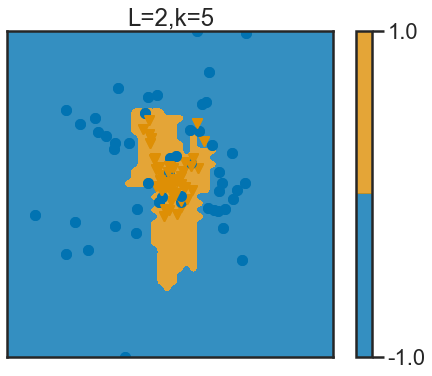

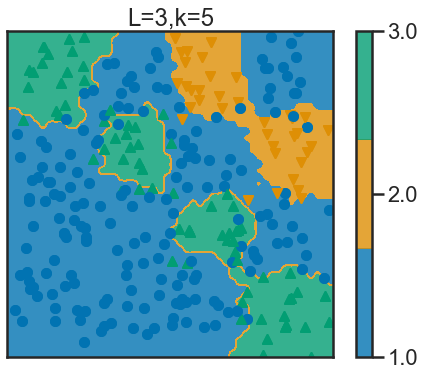

In [6]:
# Testing now for all datasets

n_neighbors = 5
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)

for X, y in [(X1, y1), (X2, y2), (X3, y3), (X4, y4)]:
    knn.fit(X, y)
    plt.figure()
    plot_2d(X, y)
    n_labels = len(np.unique(y))
    frontiere_new(knn, X, y, w=None, step=50, alpha_choice=1,
                  n_labels=n_labels, n_neighbors=n_neighbors)

### Question 4 : Predictions with different values of K

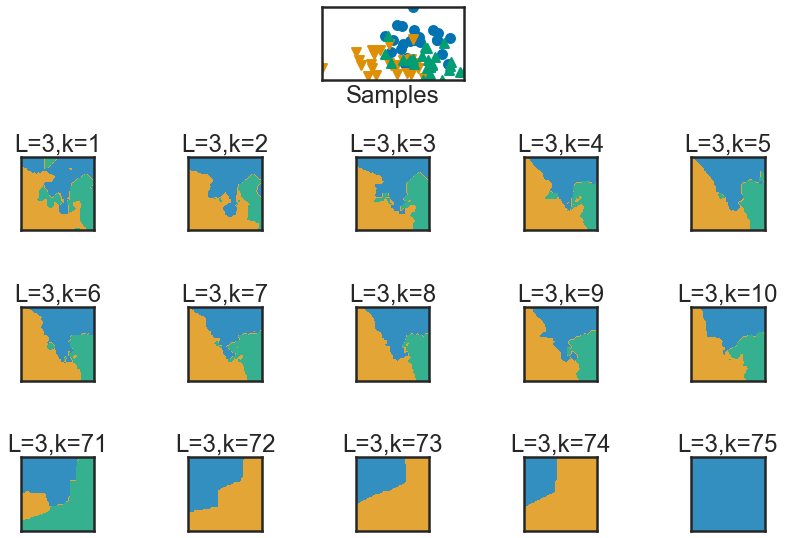

In [7]:
X_train = X2[::2]
Y_train = y2[::2]
X_test = X2[1::2]
Y_test = y2[1::2]

# Displaying the predictions when varying the value of k

plt.figure(3, figsize=(12, 8))
plt.subplot(4, 5, 3)
plot_2d(X_train, Y_train)
plt.xlabel('Samples')
ax = plt.gca()
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

for n_neighbors in list(range(1, 11)) + list(range(X_train.shape[0] - 4, X_train.shape[0] + 1)):
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, Y_train)
    if n_neighbors < 11:
        plt.subplot(4, 5, 5 + n_neighbors)
    else:
        plt.subplot(4, 5, n_neighbors % (X_train.shape[0] - 20))
    n_labels = len(np.unique(Y_train)) 
    frontiere_new(knn, X, y, w=None, step=50, alpha_choice=1,
                  colorbar=False, samples=False, n_labels=n_labels, n_neighbors=n_neighbors)
    plt.draw()

plt.tight_layout()

The decision frontier is complicated for small values of k, especially for k=1. Indeed, this choice of k leads to overfitting. This could be explained by the fact that the classifier "learns" the training set's details and noises. On the other hand, the decision frontier is simple (too simple) for values of k close to n, especially for k=n. In this case, the frontier completely disappears and only the most represetend label remains, it is thus assigned to every point of the dataset.

### Question 5 : Fraction of Errors on Training and Testing Set

In [8]:
# Scores on train data
n_neighbors = 1

knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)

# Using knn.score, on test and train
# knn.score returns the mean accuracy on the given data, so the fraction of errors corresponds to 1-knn.score
print(f'The fraction of errors on the training data is {1 - knn.score(X_train, Y_train):.3f}')
print(f'The fraction of errors on the testing data is {1 - knn.score(X_test, Y_test):.3f}')

The fraction of errors on the training data is 0.000
The fraction of errors on the testing data is 0.253


We notice that the fraction of errors on our training data when k=1 is 0. It confirms the fact that this value of k leads to overfitting. And since we predict on the same set as the one we trained on, it has a 100% accuracy.

### Scores on left out data

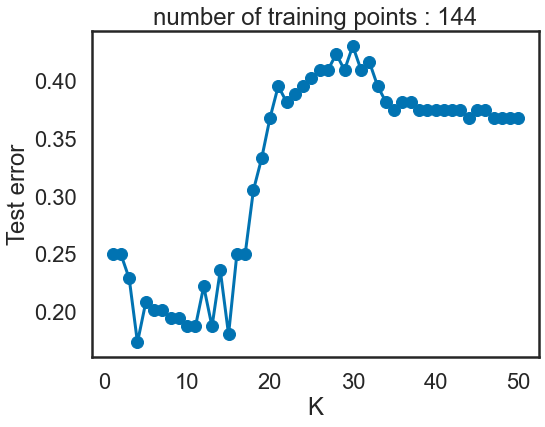

In [9]:
n1 = n2 = 200
sigma = 0.1
data4 = rand_checkers(2 * n1, 2 * n2, sigma)

X_train = X4[::2]
Y_train = y4[::2].astype(int)
X_test = X4[1::2]
Y_test = y4[1::2].astype(int)

# Instantiating ErrorCurve with k_range=range(1, 51)
error_curve = ErrorCurve(k_range=range(1, 51))

# Fitting it and plotting it
error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
plt.figure()
error_curve.plot()

We notice that the test error increases as K increases. The best value here is k=4.

### Question 6 : Error Curves as a function of K

For n = 100, the optimal k is 3 with a test error of 0.135
For n = 500, the optimal k is 32 with a test error of 0.094
For n = 1000, the optimal k is 31 with a test error of 0.091


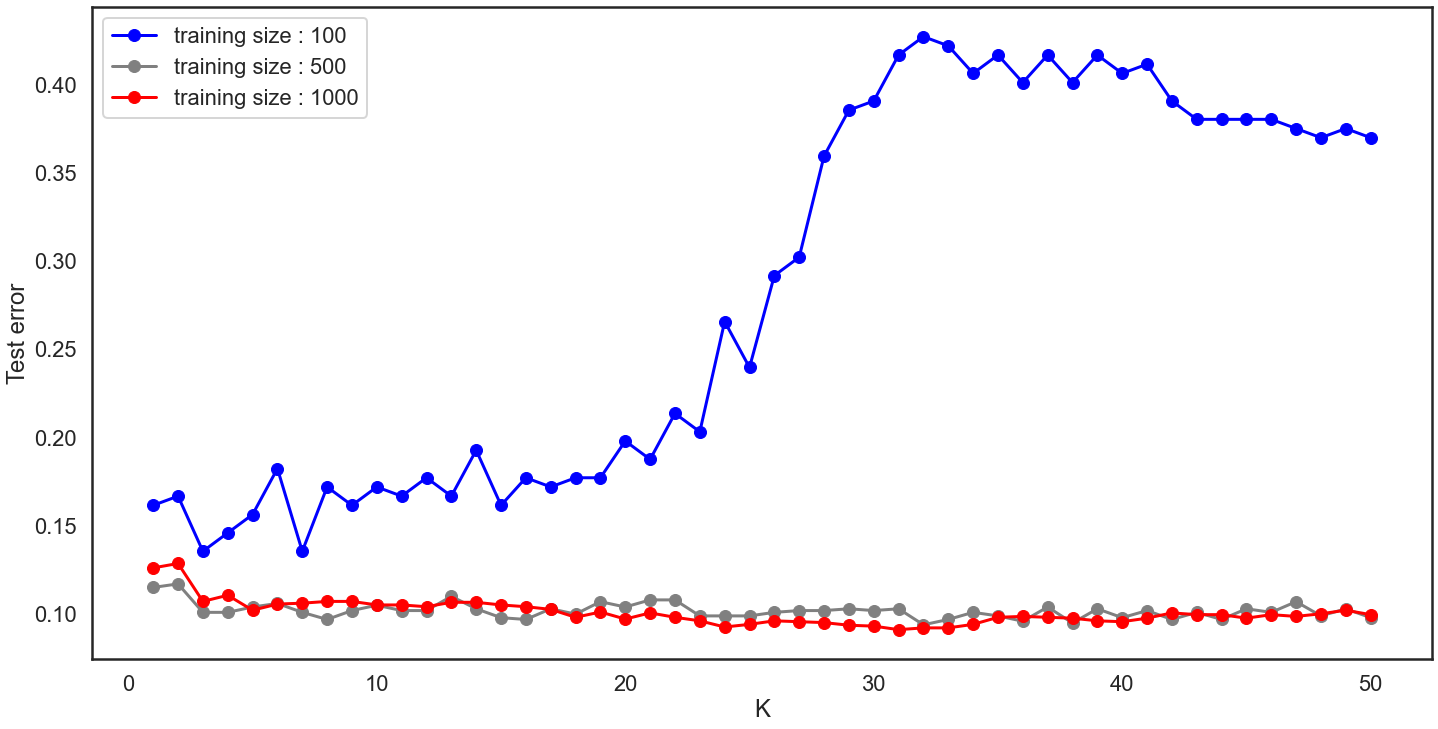

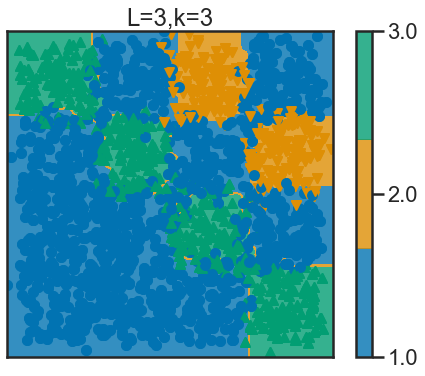

In [10]:
collist = ['blue', 'grey', 'red', 'purple', 'orange', 'salmon', 'black',
           'fuchsia']

sigma = 0.1

plt.figure(5, figsize=(24, 12))

range_n_samples = [100, 500, 1000]
niter = len(range_n_samples)

for n in range(niter):
    n1 = n2 = range_n_samples[n]
    X_train, Y_train = rand_checkers(n1, n2, sigma)
    X_test, Y_test = rand_checkers(n1, n2, sigma)
    error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
    errors = list(error_curve.errors)
    optimal_k = np.argmin(errors) + 1
    print(f'For n = {range_n_samples[n]}, the optimal k is {optimal_k} with a test error of {min(errors):.3f}')
    error_curve.plot(maketitle=False, color=collist[n])
    
plt.legend(["training size : %d" % n for n in range_n_samples],
           loc='upper left')

plt.close(6)
plt.figure(6)
plot_2d(X_train, Y_train)
n_neighbors = 40
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)

frontiere_new(knn, X_train, Y_train, w=None, step=50, alpha_choice=1)

We notice that the optimal k is small for n = 100 but is larger and almost the same for a training size of 500 and 1000, where the best k yields lower test errors than those of the training set of size 100.

### Question 7 : Pros and Cons of the method

This method manages to detect the k that minimizes the test error for various training sizes, which guarantees having the highest accuracy possible (for a specific training size and a given range of values of k).
However, this can be problematic because the best value of k can change depending on the range that we choose. Moreover, it fails at returning the best k associated with the optimal test error value amongst all possible training sizes (not just the ones given explicitly to the model). This method is also time-consuming, as it has to build a classifier each time it iterates over a value of k, for each training size.

### Application to the DIGITS dataset

### Question 8 : KNN on DIGITS Dataset

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0
 9 8 9 8 4 1 7 7 3 5 1 0 0]
1797
[[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
  15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
   0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
   0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
   3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
  16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
   0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
 [ 0.  0.  0.  4. 15. 12.  0.  0.  0.  0.  3. 16. 15. 14.  0.  0.  0.  0.
   8. 13.  8. 16.  0.  0.  0.  0.  1.  6. 15. 11.  0.  0.  0.  1.  8. 13.
  15.  1.  0.  0.  0.  9. 16. 16.  5.  0.  0.  0.  0.  3. 13. 16. 16. 11.
   5.  0.  0.  0.  

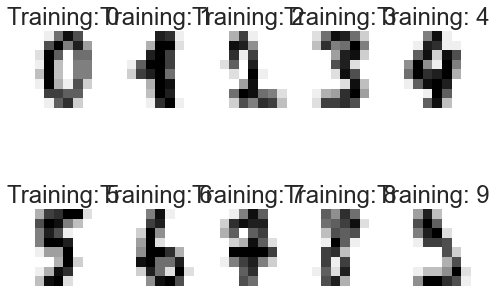

In [11]:
# test k-NN on digits dataset

# The digits dataset
digits = datasets.load_digits()

print(type(digits))

# inspect digits attributes:
print(digits.keys())
print(digits.target[:50])
print(len(digits.data))
print(digits.data[0:5])
print(digits.data.shape)
print(digits['data'][0])
print(digits['images'][0])
print(digits.data[0] == digits['data'][0])


for idx, (img, lbl) in enumerate(list(zip(digits.images,
                                          digits.target))[10:20]):
    plt.subplot(2, 5, idx + 1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='None')
    plt.title('Training: %i' % lbl)

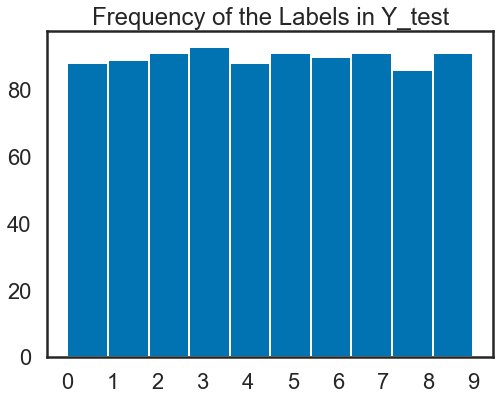

In [12]:
# Splitting the data into training sets and testing sets using the same method as before
X_digits_train = digits.data[::2]
Y_digits_train = digits.target[::2]
X_digits_test = digits.data[1::2]
Y_digits_test = digits.target[1::2]

# Plotting the histogram of Y_test:
plt.figure()
plt.hist(Y_digits_test)
plt.xticks(np.arange(0, 10, 1))
plt.title('Frequency of the Labels in Y_test');

We notice that the labels are quite equally represented over the whole testing set.

In [13]:
# Fitting & printing scores for different values of k
range_k = [1, 5, 10, 30, 50, 70, 100]
for k in range_k:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_digits_train, Y_digits_train) 
    print(f'For k = {k}, the score is: {knn.score(X_digits_test, Y_digits_test):.3f}')

For k = 1, the score is: 0.987
For k = 5, the score is: 0.978
For k = 10, the score is: 0.963
For k = 30, the score is: 0.944
For k = 50, the score is: 0.927
For k = 70, the score is: 0.912
For k = 100, the score is: 0.895


We notice that as the number of neighbors increases, the score decreases, so the best choice of k would be 1.

### Question 9 : Confusion Matrix 

[[87  0  0  0  1  0  0  0  0  0]
 [ 0 74  4  1  0  0  1  0  2  7]
 [ 1  3 81  2  0  0  0  1  3  0]
 [ 1  0  1 82  0  2  0  3  3  1]
 [ 1  2  0  0 83  0  0  2  0  0]
 [ 1  0  0  0  0 81  1  0  0  8]
 [ 0  1  0  0  0  0 89  0  0  0]
 [ 0  0  0  0  0  0  0 91  0  0]
 [ 0  6  2  4  0  3  0  0 65  6]
 [ 0  4  0  0  5  3  0  6  2 71]]


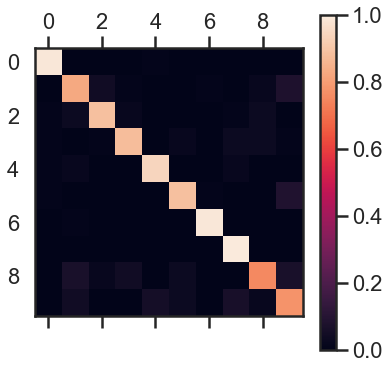

In [14]:
# Predicting Y_digits on test set
Y_digits_pred = knn.predict(X_digits_test)

# Computing confusion matrix
conf_mat = metrics.confusion_matrix(Y_digits_test, Y_digits_pred)
print(conf_mat)

# Normalizing CM so that each row sums to 1
conf_mat_normalized = conf_mat.astype(float) / conf_mat.sum(axis=1)[:, np.newaxis]

# Plotting normalized confusiong matrix
ax = plt.matshow(conf_mat_normalized)
cax = plt.colorbar(ax)

We notice that classes 0, 6 and 7 have been predicted the best and that class 8 has the worst predictions. Overall it seems like there is no confusion between the different classes and that there hasn't been any mislabelling.

### Question 10 : Method to choose K -- Cross-Validation

We suggest to proceed with cross-validation. We split the data set into 20 folds (the default value defined in our class). We then train each value of k on the whole dataset, except one of the folds (Leave One Out) that we test the classifier on. We repete the procedure until we find the value of k that minimizes the error.

[0.96995828 0.93591794 0.91147427 0.89193324 0.87173157 0.85302503
 0.82878999]


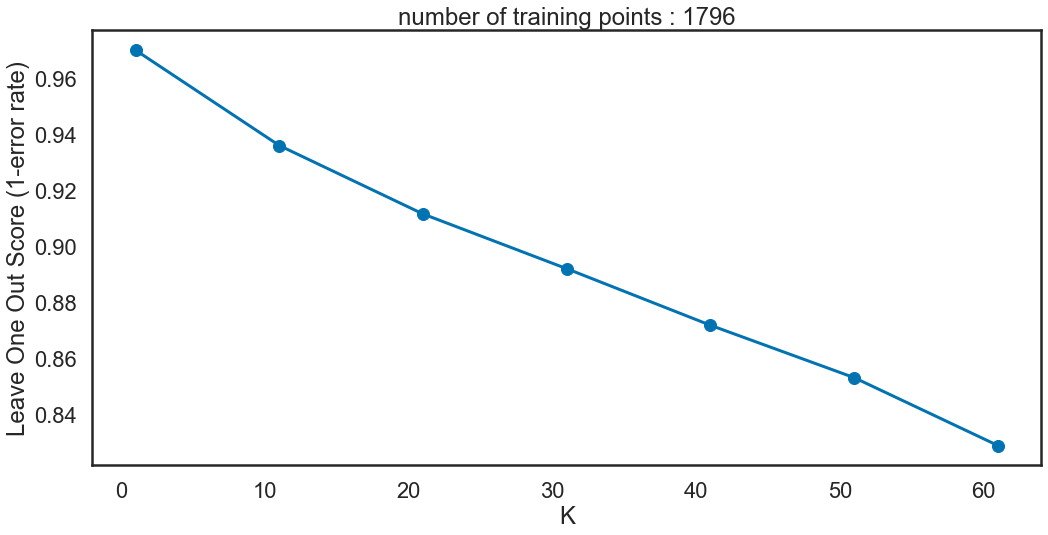

In [15]:
# Estimating k with cross-validation

loo_curve = LOOCurve(k_range=list(range(1, 71, 10)))
loo_curve.fit_curve(digits.data, digits.target)
print(loo_curve.cv_scores)

plt.figure(figsize=(17, 8))
loo_curve.plot()

In this case, the value of k with the highest score (lowest error) is 1. We notice that the scores decrease as k increases, therefore we choose k=1.

### Question 11 : Weighted $k$-NN classifier

In [16]:
# Implementing weights for the kNN classifier

def weights(dist, h):
    """Returns an array of weights, exponentially decreasing in the square
    of the distance.

    Parameters
    ----------
    dist : a one-dimensional array of distances.

    Returns
    -------
    weight : array of the same size as dist
    """
    return np.exp(-dist ** 2 / h)

# Implementing a version of our KNNClassifier using weights

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=1, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.weights = weights

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        distances = metrics.pairwise.pairwise_distances(X, self.X_)
        indexes = np.argsort(distances, axis=1)
        neighbors = indexes[:, :self.n_neighbors]
        Y_neighbors = self.y_[neighbors]
        
        # The case where no weights have been specified
        if(self.weights == 'uniform'):
            y_pred = stats.mode(Y_neighbors, axis=1)[0]
            return y_pred.astype(int) 
        
        # The case where weights have been specified
        else :
            weight = self.weights(np.sort(distances, axis=1)[:, :n_neighbors])
            y_pred = weighted_mode(Y_neighbors, weight, axis=1)[0]
            return y_pred.astype(int)
            
# Comparing our implementation with scikit-learn

n_neighbors = 5
h = 0.1

def compare(i, X, y):
    X_train = X2[::2]
    Y_train = y2[::2]
    X_test = X2[1::2]
    Y_test = y2[1::2]

    # Our classifier
    wknn = KNNClassifier(n_neighbors=n_neighbors, weights=partial(weights, h=h))
    wknn.fit(X_train, Y_train)
    Y_pred_w = wknn.predict(X_test)

    # Scikit-learn
    wsknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=partial(weights, h=h))
    wsknn.fit(X_train, Y_train)
    Y_pred_skl_w = wsknn.predict(X_test)

    # Checking that all labels match
    if np.all(list(Y_pred_skl_w) == list(Y_pred_w)):
        print(f'All the labels match for dataset {i}.')
    else:
        print(f"Labels don't match for dataset {i}.")
        
# Comparing for dataset 1
compare(1, X1, y1)

# Comparing for dataset 2
compare(2, X2, y2)

# Comparing for dataset 3
compare(3, X3, y3)
        
# Comparing for dataset 4
compare(4, X4, y4)

All the labels match for dataset 1.
All the labels match for dataset 2.
All the labels match for dataset 3.
All the labels match for dataset 4.


It seems like our predictions correspond to the ones yielded by scikit-learn's classifier. It means that our implementation is correct.

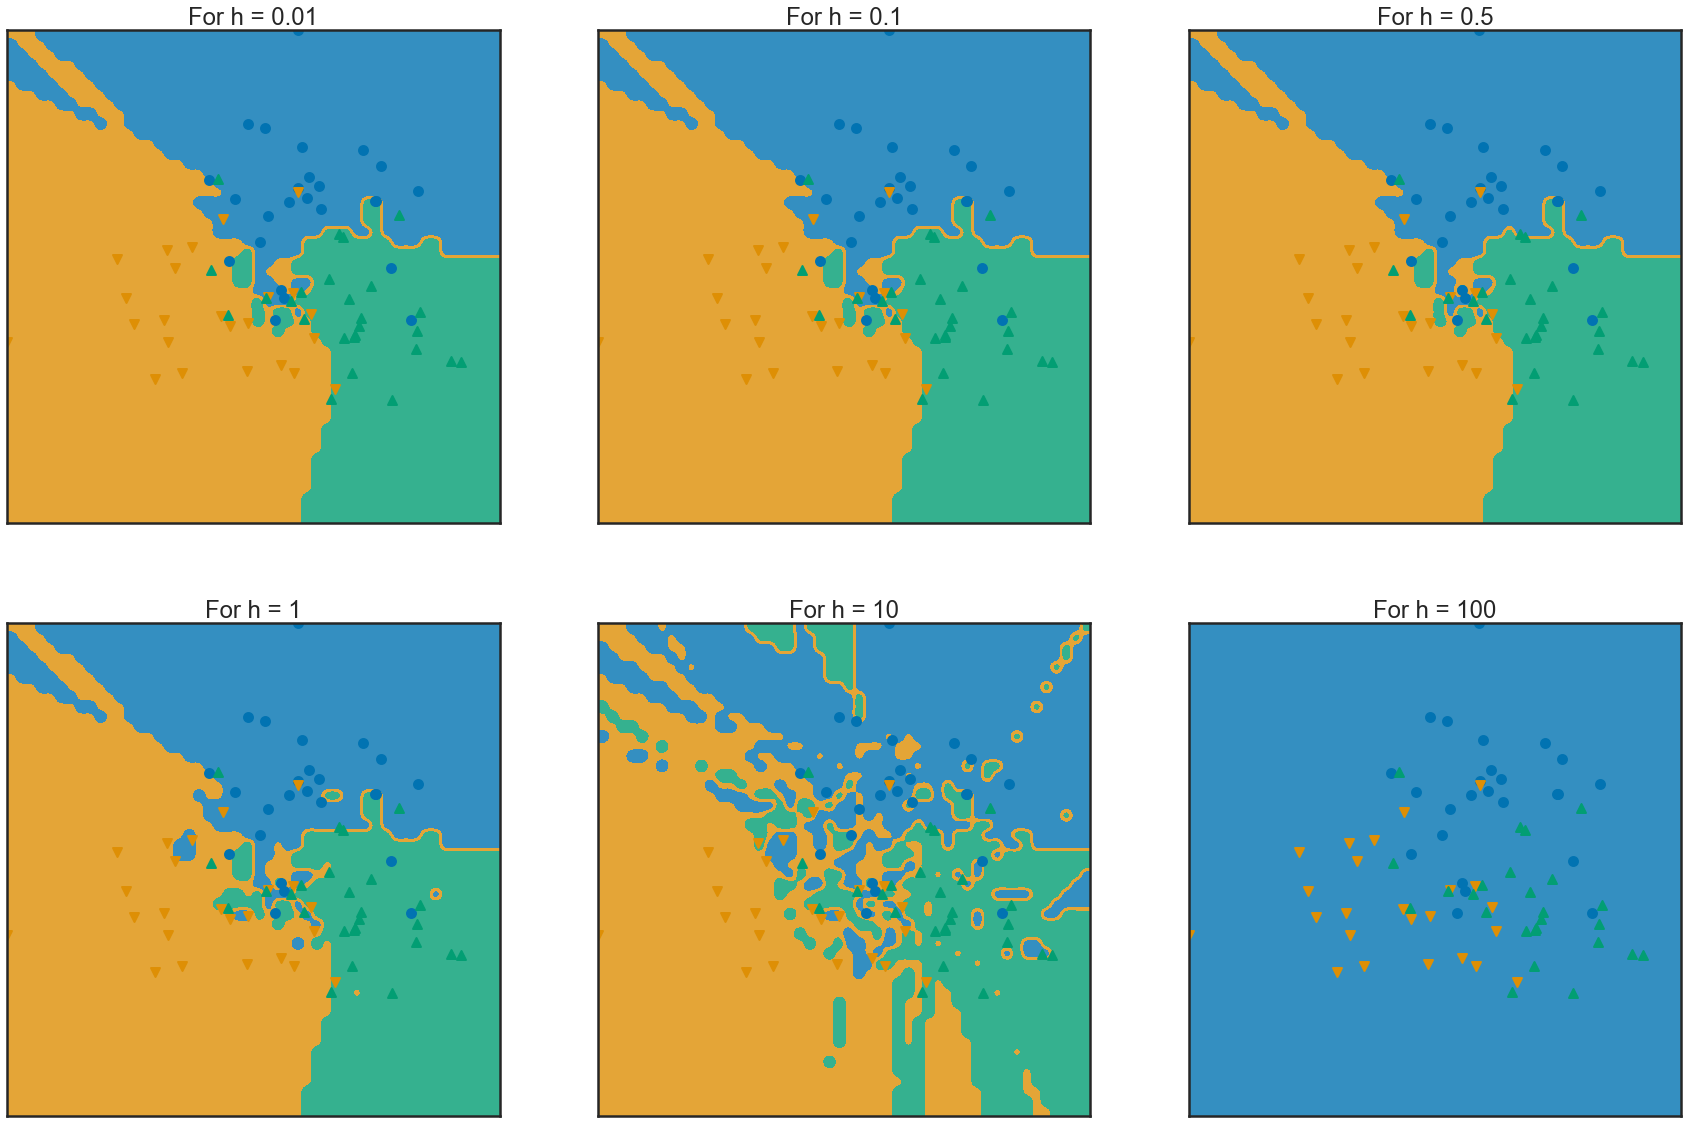

In [17]:
X_train = X2[::2]
Y_train = y2[::2]

# Testing the impact of h on the classification frontiers
range_h = [0.01, 0.1, 0.5, 1, 10, 100]
plt.figure(figsize=(30, 20))
for h in range_h:
    wknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=partial(weights, h))
    wknn.fit(X_train, Y_train)
    plt.subplot(2, 3, range_h.index(h) + 1)
    plot_2d(X_train, Y_train)
    frontiere_new(wknn, X_train, Y_train, w=None, step=50, alpha_choice=1, colorbar=False, samples=False)
    plt.title(f'For h = {h}')

We notice that for small values of h, the decision frontier is simpler than for larger values of h, as we are able to  clearly discern between the three labels. This frontier becomes more complicated as h takes larger values (greater than 1). Finally, for very large values of h (h=100), the frontier completely disappears (just like when we choose k=n). Therefore, it is safe to assume that the optimal value of h should be between 0 and 1.